In [48]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os

In [49]:
def my_seed_everywhere(seed: int = 42):
    random.seed(seed) # random
    np.random.seed(seed) # np
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    tf.random.set_seed(seed) # tensorflow

my_seed = 42
my_seed_everywhere(my_seed)

In [50]:
df = pd.read_csv('/content/sample_data/onion_final.csv', index_col=0)
df = df.dropna(axis=0)
df = df.reset_index(drop=True)
df['Date'] = pd.to_datetime(df['Date'])
df['DayOfWeek'] = df['Date'].dt.dayofweek

In [51]:
df = df.drop(['Temp'],axis=1)
df = df.drop(['Oil'],axis=1)
df = df.drop(['Sup'],axis=1)
df = df.drop(['Avg_Price'], axis=1)

df['DayOfWeek'] = df['DayOfWeek'].astype('category')
df = pd.get_dummies(df, columns =['DayOfWeek'], prefix='W', drop_first=True)

df.tail()

,Date,Rain,Wind,sobimul,nongmul,Price,Produced,W_1,W_2,W_3,W_4
2390,2022-09-26,0.0,1.7,2.5,8.7,2601.0,1576752,0,0,0,0
2391,2022-09-27,0.0,1.6,2.5,8.7,2601.0,1576752,1,0,0,0
2392,2022-09-28,0.0,1.8,2.5,8.7,2601.0,1576752,0,1,0,0
2393,2022-09-29,0.0,1.4,2.5,8.7,2480.0,1576752,0,0,1,0
2394,2022-09-30,0.0,1.6,2.5,8.7,2480.0,1576752,0,0,0,1


In [52]:
from sklearn.preprocessing import MinMaxScaler
input_indicator = df.loc[:,['Rain', 'Wind', 'sobimul', 'nongmul', 'Produced', 'W_1', 'W_2', 'W_3', 'W_4']]
target_indicator = df.loc[:,['Price']].values[:]

scaler_input = MinMaxScaler()
scaler_target = MinMaxScaler()
scaled_input_indicator = scaler_input.fit_transform(input_indicator)
scaled_target_indicator = scaler_target.fit_transform(target_indicator) # 가격 관련 지표에 스케일링

x = np.concatenate((scaled_target_indicator, scaled_input_indicator), axis=1)
y = x[:, [0]]

print(x)
print(y.shape)

[[0.37931034 0.         0.61403509 ... 1.         0.         0.        ]
 [0.35632184 0.         0.36842105 ... 0.         1.         0.        ]
 [0.35632184 0.         0.19298246 ... 0.         0.         1.        ]
 ...
 [0.52576937 0.         0.19298246 ... 1.         0.         0.        ]
 [0.48090471 0.         0.12280702 ... 0.         1.         0.        ]
 [0.48090471 0.         0.15789474 ... 0.         0.         1.        ]]
(2395, 1)


In [94]:
# 7일치의 input으로 7일치의 output을 생산
seq_length = 7
predict_day = 7
dataX = [] 
dataY = [] 
for i in range(0, int(len(y) - seq_length - predict_day)):
    _x = x[i : i + seq_length]
    _y = y[i + predict_day : i + seq_length + predict_day] 
    dataX.append(_x) 
    dataY.append(_y) 
print(len(dataX))
print(len(dataY))

2381
2381


In [95]:
# 7의 배수로 설정해야 batch에서 오류가 발생하지 않음
train_size = 1428
validation_size = 476
test_size = 476

trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])
validX = np.array(dataX[train_size:train_size+validation_size])
validY = np.array(dataY[train_size:train_size+validation_size])
testX = np.array(dataX[train_size+validation_size:train_size+validation_size+test_size])
testY = np.array(dataY[train_size+validation_size:train_size+validation_size+test_size])

print(trainX.shape)
print(trainY.shape)
print(validX.shape)
print(validY.shape)
print(testX.shape)
print(testY.shape)

(1428, 7, 10)
(1428, 7, 1)
(476, 7, 10)
(476, 7, 1)
(476, 7, 10)
(476, 7, 1)


In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Activation
from tensorflow import keras

In [56]:
class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

In [57]:
input_columns = 10 # 데이터 셋의 '열' 개수 (dataX) / dataset's columns (dataX)

model = Sequential()
model.add(LSTM(16, batch_input_shape=(7, 7, input_columns), return_sequences=True, stateful=True, dropout=0.1))
model.add(LSTM(16, return_sequences=True, stateful=True, dropout=0.1))
model.add(Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (7, 7, 16)                1728      
                                                                 
 lstm_5 (LSTM)               (7, 7, 16)                2112      
                                                                 
 dense_2 (Dense)             (7, 7, 1)                 17        
                                                                 
Total params: 3,857
Trainable params: 3,857
Non-trainable params: 0
_________________________________________________________________


In [58]:
from tensorflow.keras.callbacks import EarlyStopping
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model-onion.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)

In [59]:
keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [60]:
custom_hist = CustomHistory()
custom_hist.init()

In [61]:
for epoch_idx in range(100):
  print('epochs:' + str(epoch_idx))
  hist = model.fit(trainX, trainY, validation_data=(validX, validY), epochs=1, batch_size=7, verbose=2, shuffle=False, callbacks=[checkpoint_cb, custom_hist, early_stopping_cb])
  model.reset_states()

epochs:0
204/204 - 4s - loss: 0.0370 - mae: 0.1322 - val_loss: 0.0489 - val_mae: 0.1980 - 4s/epoch - 19ms/step
epochs:1
204/204 - 1s - loss: 0.0242 - mae: 0.1125 - val_loss: 0.0824 - val_mae: 0.2685 - 977ms/epoch - 5ms/step
epochs:2
204/204 - 1s - loss: 0.0194 - mae: 0.1042 - val_loss: 0.0782 - val_mae: 0.2631 - 1s/epoch - 6ms/step
epochs:3
204/204 - 1s - loss: 0.0172 - mae: 0.0983 - val_loss: 0.0769 - val_mae: 0.2622 - 1s/epoch - 6ms/step
epochs:4
204/204 - 1s - loss: 0.0153 - mae: 0.0925 - val_loss: 0.0652 - val_mae: 0.2407 - 1s/epoch - 6ms/step
epochs:5
204/204 - 1s - loss: 0.0140 - mae: 0.0883 - val_loss: 0.0554 - val_mae: 0.2208 - 964ms/epoch - 5ms/step
epochs:6
204/204 - 1s - loss: 0.0120 - mae: 0.0801 - val_loss: 0.0469 - val_mae: 0.2023 - 1s/epoch - 5ms/step
epochs:7
204/204 - 1s - loss: 0.0111 - mae: 0.0764 - val_loss: 0.0357 - val_mae: 0.1765 - 1s/epoch - 5ms/step
epochs:8
204/204 - 1s - loss: 0.0099 - mae: 0.0720 - val_loss: 0.0281 - val_mae: 0.1558 - 1s/epoch - 6ms/step
epo

In [62]:
a = 7

In [63]:
model.evaluate(trainX, trainY, batch_size = a)

204/204 [==============================] - 1s 3ms/step - loss: 0.0046 - mae: 0.0500


[0.004624024964869022, 0.05004009231925011]

In [64]:
print(custom_hist.train_loss)

[0.03696367144584656, 0.024217909201979637, 0.019384240731596947, 0.017237359657883644, 0.015256625600159168, 0.014033532701432705, 0.011965631507337093, 0.011106343939900398, 0.009921925142407417, 0.009317181073129177, 0.008968829177320004, 0.009035552851855755, 0.008848744444549084, 0.008268607780337334, 0.007883818820118904, 0.007992962375283241, 0.007410755846649408, 0.007517070043832064, 0.007402242626994848, 0.007268587592989206, 0.007524522487074137, 0.007291266694664955, 0.007934833876788616, 0.007172449491918087, 0.0069810133427381516, 0.0070791603066027164, 0.007381114177405834, 0.006851674988865852, 0.006115084048360586, 0.007014722563326359, 0.0067367334850132465, 0.006285431794822216, 0.006499664392322302, 0.005935318768024445, 0.006323155015707016, 0.005952096544206142, 0.006080084480345249, 0.006348108407109976, 0.006019026041030884, 0.006253078114241362, 0.00539515120908618, 0.005846607964485884, 0.005811454262584448, 0.005572169553488493, 0.005414696875959635, 0.005435

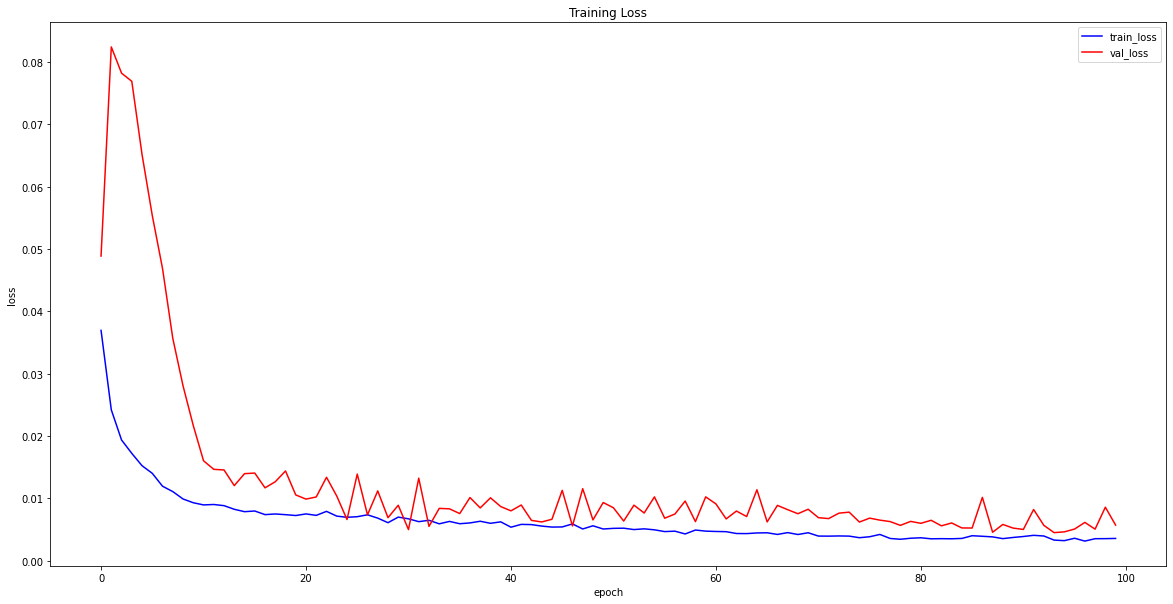

In [65]:
plt.figure(figsize=(20,10))
plt.plot(custom_hist.train_loss, color = 'blue', label = 'train_loss')
plt.plot(custom_hist.val_loss, color = 'red', label = 'val_loss')
plt.title('Training Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [66]:
from keras.models import load_model
model = load_model('/content/best-model-onion.h5')

Train Data *평가*

In [67]:
model.evaluate(trainX, trainY, batch_size=a)

204/204 [==============================] - 1s 3ms/step - loss: 0.0047 - mae: 0.0499


[0.004663817584514618, 0.049884263426065445]

In [68]:
predicted_price_train = model.predict(trainX, batch_size=a, verbose=1) 

204/204 [==============================] - 1s 2ms/step


In [69]:
trainY_test = np.delete(trainY, np.s_[1:a], axis=1)
predicted_price_train_test = np.delete(predicted_price_train, np.s_[1:a], axis=1)

trainY_test = np.reshape(trainY_test, (1428, 1))
predicted_price_train_test = np.reshape(predicted_price_train_test, (1428, 1))
print(trainY_test.shape)
print(predicted_price_train_test.shape)

(1428, 1)
(1428, 1)


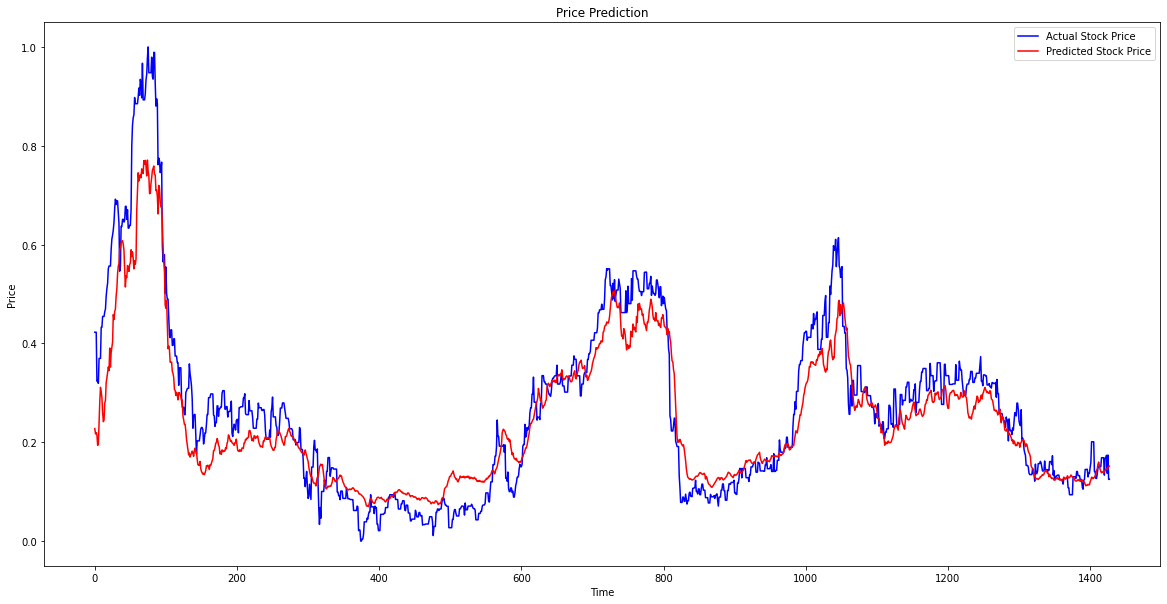

In [70]:
plt.figure(figsize=(20,10))
plt.plot(trainY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_train_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [71]:
predicted_price_train_test = np.reshape(predicted_price_train_test, (1428, ))
predicted_price_train_test = scaler_target.inverse_transform(predicted_price_train_test.reshape(-1,1))

print(predicted_price_train_test, predicted_price_train_test.shape)

trainY_test = scaler_target.inverse_transform(trainY_test.reshape(-1,1))

print(trainY_test, trainY_test.shape)

[[1797.2383]
 [1767.9032]
 [1774.588 ]
 ...
 [1585.4985]
 [1587.8837]
 [1592.32  ]] (1428, 1)
[[2323.]
 [2323.]
 [2323.]
 ...
 [1653.]
 [1520.]
 [1520.]] (1428, 1)


In [72]:
from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(trainY_test, predicted_price_train_test) 
np.sqrt(MSE)

187.9824045584249

In [73]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(trainY_test, predicted_price_train_test)

136.71057316969757

Val Date 평가


In [74]:
model.evaluate(validX, validY, batch_size=a)

68/68 [==============================] - 0s 3ms/step - loss: 0.0045 - mae: 0.0533


[0.0045211464166641235, 0.05327194556593895]

In [75]:
predicted_price_valid = model.predict(validX, batch_size=a, verbose=1) 

68/68 [==============================] - 0s 2ms/step


(476, 1)
(476, 1)


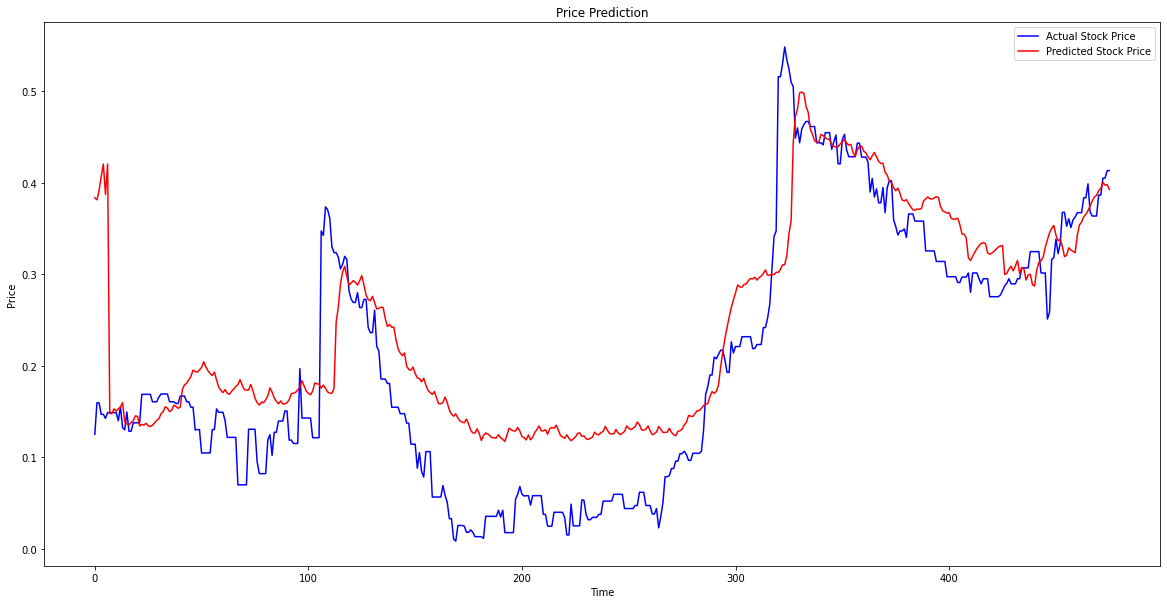

In [76]:
validY_test = np.delete(validY, np.s_[1:a], axis=1)
predicted_price_valid_test = np.delete(predicted_price_valid, np.s_[1:a], axis=1)

validY_test = np.reshape(validY_test, (476, 1))
predicted_price_valid_test = np.reshape(predicted_price_valid_test, (476, 1))
print(validY_test.shape)
print(predicted_price_valid_test.shape)

plt.figure(figsize=(20,10))
plt.plot(validY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_valid_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [77]:
predicted_price_valid_test = np.reshape(predicted_price_valid_test, (476, ))
predicted_price_valid_test = scaler_target.inverse_transform(predicted_price_valid_test.reshape(-1,1))

print(predicted_price_valid_test, predicted_price_valid_test.shape)

validY_test = scaler_target.inverse_transform(validY_test.reshape(-1,1))

print(validY_test, validY_test.shape)

[[2218.1912]
 [2211.8145]
 [2239.56  ]
 [2280.2097]
 [2317.1792]
 [2227.612 ]
 [2317.692 ]
 [1581.3333]
 [1581.3901]
 [1595.111 ]
 [1588.4222]
 [1595.134 ]
 [1600.7567]
 [1613.3644]
 [1557.3263]
 [1550.8817]
 [1547.5696]
 [1554.7162]
 [1559.9995]
 [1574.2635]
 [1573.0127]
 [1544.8092]
 [1549.3357]
 [1547.2853]
 [1552.8372]
 [1545.0663]
 [1542.8849]
 [1546.7059]
 [1553.6107]
 [1561.2513]
 [1565.8403]
 [1580.4412]
 [1586.7056]
 [1601.3563]
 [1597.3424]
 [1586.9374]
 [1591.1917]
 [1605.4581]
 [1602.4692]
 [1596.6545]
 [1600.5347]
 [1652.2316]
 [1665.9762]
 [1670.5957]
 [1681.2655]
 [1690.5924]
 [1709.6919]
 [1705.1884]
 [1703.1149]
 [1710.4152]
 [1717.3207]
 [1733.9445]
 [1718.7472]
 [1707.3564]
 [1698.9019]
 [1693.3234]
 [1703.6501]
 [1680.3806]
 [1659.8689]
 [1649.8223]
 [1643.0076]
 [1652.1705]
 [1641.3544]
 [1637.8477]
 [1646.3221]
 [1653.3352]
 [1661.1685]
 [1666.1912]
 [1681.4647]
 [1665.1488]
 [1651.8579]
 [1650.4469]
 [1650.7284]
 [1667.1793]
 [1649.5691]
 [1626.7487]
 [1613.3976]

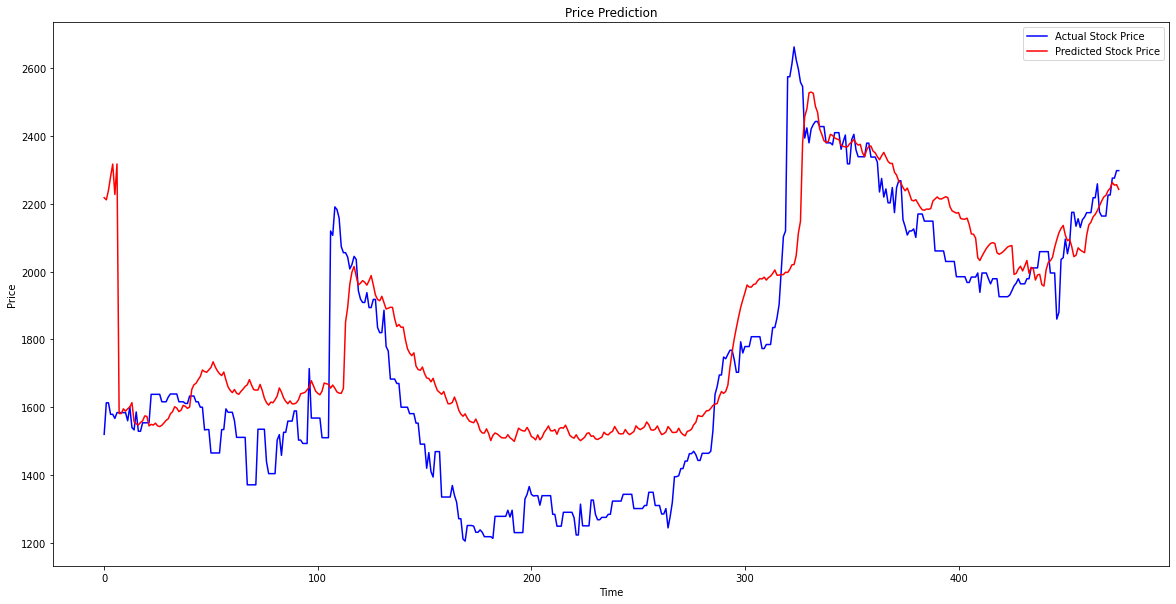

In [78]:
plt.figure(figsize=(20,10))
plt.plot(validY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_valid_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [79]:
from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(validY_test, predicted_price_valid_test) 
np.sqrt(MSE)

199.2274946077702

In [80]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(validY_test, predicted_price_valid_test)

153.1386457170759

Test Data 평가

In [81]:
model.evaluate(testX, testY, batch_size=a)

68/68 [==============================] - 0s 3ms/step - loss: 0.0139 - mae: 0.0806


[0.013897126540541649, 0.08058271557092667]

In [82]:
predicted_price_test = model.predict(testX, batch_size=a, verbose=1)

68/68 [==============================] - 0s 2ms/step


(476, 1)
(476, 1)


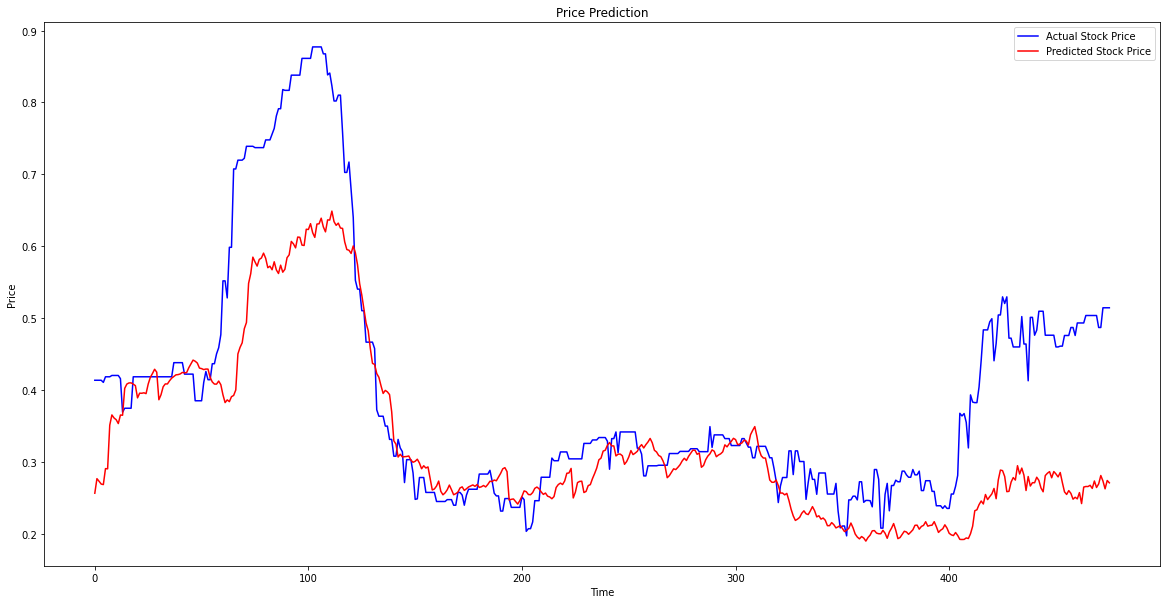

In [83]:
testY_test = np.delete(testY, np.s_[1:a], axis=1)
predicted_price_test_test = np.delete(predicted_price_test, np.s_[1:a], axis=1)

testY_test = np.reshape(testY_test, (476, 1))
predicted_price_test_test = np.reshape(predicted_price_test_test, (476, 1))
print(testY_test.shape)
print(predicted_price_test_test.shape)

plt.figure(figsize=(20,10))
plt.plot(testY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_test_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [84]:
predicted_price_test_test = np.reshape(predicted_price_test_test, (476, ))
predicted_price_test_test = scaler_target.inverse_transform(predicted_price_test_test.reshape(-1,1))

print(predicted_price_test_test, predicted_price_test_test.shape)

testY_test = scaler_target.inverse_transform(testY_test.reshape(-1,1))

print(testY_test, testY_test.shape)

[[1874.0436]
 [1928.656 ]
 [1918.8463]
 [1908.37  ]
 [1906.4805]
 [1966.3472]
 [1965.5875]
 [2129.4988]
 [2167.8633]
 [2156.524 ]
 [2150.0195]
 [2135.431 ]
 [2167.5212]
 [2166.7314]
 [2267.6436]
 [2283.6262]
 [2287.939 ]
 [2288.1455]
 [2283.508 ]
 [2277.837 ]
 [2231.8838]
 [2249.5073]
 [2249.2095]
 [2250.8855]
 [2247.835 ]
 [2283.7717]
 [2308.909 ]
 [2323.3406]
 [2339.2708]
 [2328.3   ]
 [2224.8337]
 [2243.6318]
 [2273.5093]
 [2284.2725]
 [2284.0483]
 [2296.1272]
 [2305.942 ]
 [2312.3843]
 [2318.3015]
 [2319.2258]
 [2321.7078]
 [2327.3894]
 [2325.774 ]
 [2326.8193]
 [2344.9136]
 [2359.2012]
 [2373.6277]
 [2369.4072]
 [2362.5012]
 [2343.6992]
 [2341.6433]
 [2338.0564]
 [2340.066 ]
 [2339.789 ]
 [2308.6213]
 [2291.6238]
 [2283.6775]
 [2283.3838]
 [2294.9707]
 [2281.358 ]
 [2243.273 ]
 [2214.213 ]
 [2224.3447]
 [2217.7075]
 [2236.4236]
 [2240.8486]
 [2261.558 ]
 [2396.8687]
 [2421.3032]
 [2438.4907]
 [2491.5237]
 [2514.8032]
 [2661.5935]
 [2697.8857]
 [2760.013 ]
 [2742.3215]
 [2726.3682]

In [85]:
from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(testY_test, predicted_price_test_test) 
np.sqrt(MSE)

316.5716398048425

In [86]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(testY_test, predicted_price_test_test)

219.46718591000854

예측방법

In [87]:
minX1 = np.array(dataX[0:7])
minX2 = np.array(dataX[0:8])
minX3 = np.array(dataX[0:2380])
minX4 = np.array(dataX[0:train_size])

In [88]:
predicted_price_min1 = model.predict(minX1, batch_size=a, verbose=1)
predicted_price_min2 = model.predict(minX2, batch_size=a, verbose=1) 
predicted_price_min3 = model.predict(minX3, batch_size=a, verbose=1)
predicted_price_min4 = model.predict(minX4, batch_size=a, verbose=1) 

204/204 [==============================] - 1s 2ms/step


In [90]:
predicted_price_min1[0]

array([[0.24257636],
       [0.2127758 ],
       [0.19604716],
       [0.19285223],
       [0.17866859],
       [0.17391121],
       [0.19723114]], dtype=float32)

In [91]:
predicted_price_min2[0]

array([[0.19398737],
       [0.19696312],
       [0.19743334],
       [0.20653376],
       [0.19991168],
       [0.20356661],
       [0.23556557]], dtype=float32)

In [92]:
predicted_price_min3[0]

array([[0.27939177],
       [0.27981317],
       [0.27133626],
       [0.27306294],
       [0.26727262],
       [0.27159923],
       [0.2972232 ]], dtype=float32)

In [93]:
scaler_target.inverse_transform(predicted_price_min4[0].reshape(-1,1))

array([[1837.2285],
       [1756.8563],
       [1711.7391],
       [1703.1224],
       [1664.8691],
       [1652.0386],
       [1714.9324]], dtype=float32)